# Anomaly detection on Hypothyroidism dataset



*Daniele Cecca*

*Matr. 918358*

*MSc Artificial Intelligence for Science and Technology*

*Email: d.cecca@campus.unimib.it*





The project consists of an anomaly detection system for the *hypothyroidism dataset*.

The first part of the project involves **exploring the dataset**.

In the second part, we will explore four different **anomaly detection** algorithms:

- **DBSCAN**
- **LOF (Local Outlier Factor)**
- **Auto-Encoder**
- **MCD (Minimum Covariance Determinant)**

*I have decided not to create utility functions even though I could. This choice is made to enhance the readability of the notebook and to ensure that information is not hidden.*

Here we define all the import

In [1]:
!pip install gower
!pip install pyod
!pip install combo
!pip install kneed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.0-py3-none-any.whl size=196324 sha256=9c9d6e4f84fea18895c211160592a31e5d9b44012c567b14a5660a8dabcdad0b
  Stored in directory: /root/.cache/pip/wheels/15/0e/91/96b270e6741d4eece88727489411330226ff47ac1cb9ea0097
Successfully built pyod
  Preparing metadata (setup.py) ... done
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42861 sha256=3484ebb48ad4ddfaacfa81ee728315c39bd6699123ea96a2604deee6755aa78d
  Stored in directory: /root/.cache/pip/wheels/7a/48/ff/0d6e1017d8bf3d844d332736fbb268dca767162779f93ff50a
Successfully built combo


In [2]:
from google.colab import drive
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.metrics import jaccard_score

import gower
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from sklearn.manifold import TSNE
from kneed import KneeLocator

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from pyod.models import lof, auto_encoder,mcd,ecod
from pyod.models.combination import average
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from pyod.utils.example import visualize
from pyod.utils.data import evaluate_print

from sklearn import metrics

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score





Set theme

In [3]:
sns.set_theme(style="whitegrid", palette="pastel", context="notebook")


In [4]:
pastel_orange = '#FF9967'
pastel_black = '#595959'
custom_palette = [pastel_black,pastel_orange]

In [5]:
pastel_palette = [
    "#fbf8cc",  # Light yellow
    "#fde4cf",  # Light peach
    "#ffcfd2",  # Light pink
    "#f1c0e8",  # Light lavender
    "#cfbaf0",  # Light purple
    "#a3c4f3",  # Light blue
    "#90dbf4",  # Light cyan
    "#8eecf5",  # Light aqua
    "#98f5e1",  # Light turquoise
    "#b9fbc0"   # Light green
]

To get the dataset we mount google drive and we set in correct folder

In [6]:
drive.mount('/content/drive/')
%cd '/content/drive/MyDrive/unsupervised/Final_Project/Data'

Mounted at /content/drive/
/content/drive/MyDrive/unsupervised/Final_Project/Data


## Exploration of the data - EDA

### Loading data

We load the dataset

In [7]:
df = pd.read_csv('Hypothyroidism.csv', delimiter=';')

In [8]:
df.head(5)

Row     Dim_0  Dim_1=0  Dim_2=0  Dim_3=0  Dim_4=0  Dim_5=0  Dim_6=0  \
0    0  0,750000        1        0        1        1        1        1   
1    1  0,239583        1        1        1        1        1        1   
2    2  0,479167        1        1        1        1        1        1   
3    3  0,656250        0        1        1        1        1        1   
4    4  0,229167        1        1        1        1        1        1   

   Dim_7=0  Dim_8=0  ...  Dim_13=0  Dim_14=0  Dim_15=0    Dim_16    Dim_17  \
0        1        0  ...         1         1         1  0,001132  0,080780   
1        1        1  ...         1         1         1  0,000472  0,164345   
2        1        1  ...         1         1         1  0,003585  0,130919   
3        1        1  ...         1         1         1  0,001698  0,091922   
4        1        1  ...         1         1         1  0,000472  0,142061   

     Dim_18    Dim_19    Dim_20 Unnamed: 22 Unnamed: 23  
0  0,197324  0,300926  0,225000         NaN         NaN  
1  0,235786  0,537037  0,165625         NaN         NaN  
2  0,167224  0,527778  0,118750         NaN         NaN  
3  0,125418  0,337963  0,129688         NaN         NaN  
4  0,229097  0,337963  0,235938         NaN         NaN  

[5 rows x 24 columns]

Since the last columns are empty (perhaps due to some erroneous ';' additions in the data), we remove them. We also remove the first column because we already have the index in the DataFrame object.

In [9]:
df.drop(df.iloc[:,[0,-1,-2]], axis=1, inplace=True)

After the drop of the last three columns we will have 21 columns.

In [10]:
print(f'Number of columns: {len(df.columns)}')

Number of columns: 21


We rename the columns names such that they all have the same econde/format : *Dim_num*

In [11]:
columns_names=['Dim_'+str(num) for num in range(len(df.columns))]
print(columns_names)

['Dim_0', 'Dim_1', 'Dim_2', 'Dim_3', 'Dim_4', 'Dim_5', 'Dim_6', 'Dim_7', 'Dim_8', 'Dim_9', 'Dim_10', 'Dim_11', 'Dim_12', 'Dim_13', 'Dim_14', 'Dim_15', 'Dim_16', 'Dim_17', 'Dim_18', 'Dim_19', 'Dim_20']


In [12]:
df.columns=columns_names
print(df.columns)

Index(['Dim_0', 'Dim_1', 'Dim_2', 'Dim_3', 'Dim_4', 'Dim_5', 'Dim_6', 'Dim_7',
       'Dim_8', 'Dim_9', 'Dim_10', 'Dim_11', 'Dim_12', 'Dim_13', 'Dim_14',
       'Dim_15', 'Dim_16', 'Dim_17', 'Dim_18', 'Dim_19', 'Dim_20'],
      dtype='object')


Also we have that the number are written with ',' instead of '.' notation.Thus we change it.

In [13]:
#Replace , with .
df = df.replace(',', '.', regex=True)

#Convert number into string
df = df.apply(pd.to_numeric, errors='coerce')

In [14]:
df.head(5)

Dim_0  Dim_1  Dim_2  Dim_3  Dim_4  Dim_5  Dim_6  Dim_7  Dim_8  Dim_9  \
0  0.750000      1      0      1      1      1      1      1      0      1   
1  0.239583      1      1      1      1      1      1      1      1      1   
2  0.479167      1      1      1      1      1      1      1      1      1   
3  0.656250      0      1      1      1      1      1      1      1      1   
4  0.229167      1      1      1      1      1      1      1      1      1   

   ...  Dim_11  Dim_12  Dim_13  Dim_14  Dim_15    Dim_16    Dim_17    Dim_18  \
0  ...       1       1       1       1       1  0.001132  0.080780  0.197324   
1  ...       1       1       1       1       1  0.000472  0.164345  0.235786   
2  ...       1       1       1       1       1  0.003585  0.130919  0.167224   
3  ...       1       1       1       1       1  0.001698  0.091922  0.125418   
4  ...       1       1       1       1       1  0.000472  0.142061  0.229097   

     Dim_19    Dim_20  
0  0.300926  0.225000  
1  0.537037  0.165625  
2  0.527778  0.118750  
3  0.337963  0.129688  
4  0.337963  0.235938  

[5 rows x 21 columns]

### Attributes identification

We analyze the type of attributes of our dataset





In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dim_0   7200 non-null   float64
 1   Dim_1   7200 non-null   int64  
 2   Dim_2   7200 non-null   int64  
 3   Dim_3   7200 non-null   int64  
 4   Dim_4   7200 non-null   int64  
 5   Dim_5   7200 non-null   int64  
 6   Dim_6   7200 non-null   int64  
 7   Dim_7   7200 non-null   int64  
 8   Dim_8   7200 non-null   int64  
 9   Dim_9   7200 non-null   int64  
 10  Dim_10  7200 non-null   int64  
 11  Dim_11  7200 non-null   int64  
 12  Dim_12  7200 non-null   int64  
 13  Dim_13  7200 non-null   int64  
 14  Dim_14  7200 non-null   int64  
 15  Dim_15  7200 non-null   int64  
 16  Dim_16  7200 non-null   float64
 17  Dim_17  7200 non-null   float64
 18  Dim_18  7200 non-null   float64
 19  Dim_19  7200 non-null   float64
 20  Dim_20  7200 non-null   float64
dtypes: float64(6), int64(15)
memory usage

We have 21 features for each sample:
- 15 numerical, continuous
- 6 binary

We have 7200 sample.



### Missing values and duplicates

As we can see from the information above and from the following heatmap we don't have any missing values

<Axes: >

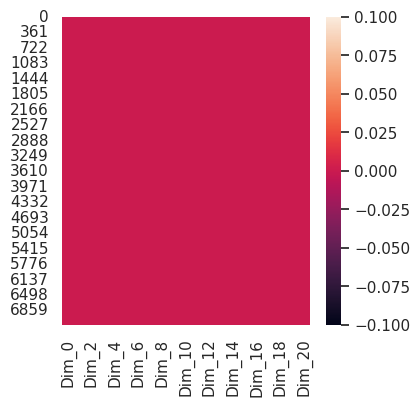

In [16]:
f, ax = plt.subplots(figsize=(4,4))
sns.heatmap(df.isnull(), ax=ax)

We also check if there are some duplicates

In [17]:
duplicate_matrix=df.duplicated(keep ='first')
print(f'Duplicates: {duplicate_matrix.sum()}')

Duplicates: 71


We remove all duplicates and keep only the first occurrence of each sample

In [18]:
df.drop_duplicates(keep='first', inplace=True)
print(df.shape)

(7129, 21)


### Univariate analysis

We explore variables one by one.
Since we have two type of attributes, we apply different methods for each type of attribute.

#### Univariate analysis-Continuous attributes




We select only the continuous features

In [19]:
df_continuous=df.loc[:, [col for col in df.columns if df[col].dtype == 'float64']]

We get some basic **statistics**

In [20]:
df_continuous.describe()

Dim_0       Dim_16       Dim_17       Dim_18       Dim_19  \
count  7129.000000  7129.000000  7129.000000  7129.000000  7129.000000   
mean      0.532653     0.009227     0.108475     0.179624     0.374209   
std       0.197311     0.043569     0.042208     0.060442     0.088791   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.375000     0.001321     0.091922     0.145485     0.324074   
50%       0.562500     0.003208     0.109192     0.173913     0.365741   
75%       0.697917     0.005094     0.119777     0.205686     0.402778   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            Dim_20  
count  7129.000000  
mean      0.173789  
std       0.056677  
min       0.000000  
25%       0.143750  
50%       0.170313  
75%       0.195313  
max       1.000000

As we can see, all the continuous attributes are within the same interval *\[0,1]* and have similar variance and mean, except the first one, Dim_0, which has values in the same interval but slightly different variance and mean. Therefore, we expect a similar distribution for all these attributes.

To have a broader and more visually inspectable view of the attributes we plot our data by using the **box plot**.

Also the box plot will be useful to have an initial insight into the outliers of our data.



<Axes: >

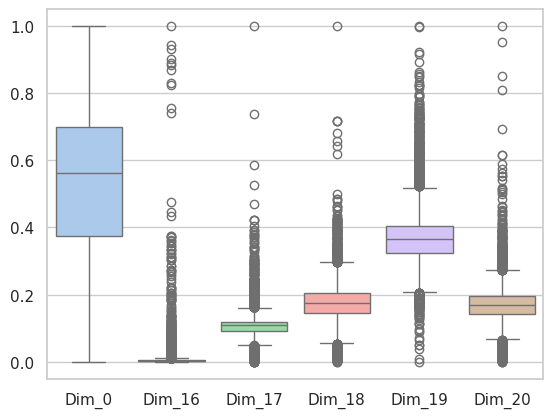

In [21]:
sns.boxplot(df_continuous)

From the previous box plots, we can deduce that we have many possible outliers,
at least from a statistical point of view.

Outliers are identified as points with values  the 3rd quartile ***(Q3) + 1.5 x IQR*** or less than the 1st quartile ***(Q1) - 1.5 x IQR.***

**IQR = Q3 - Q1**

Additionally, we can already say that distributions likely have heavy tails,
indicating that it probably does not follow a normal distribution. This implies high variance and the presence of heavy tails.

Furthermore, the positions of the medians indicate that most distributions are not symmetric.

To verify the previous assumption we diplay the distribution by plotting histogramm and we compute **Skewness** and **Kurtosis**.

If Skewnwss near 0 then is symmetric

If Kurtosis is greater than 3 than we have **leptokurtic distribution**, since the normal one have a value of 3

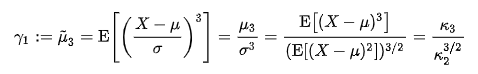

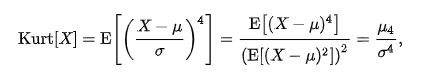

In [22]:
for col in df_continuous.columns:
  print(f"Skewness {col}: {df_continuous[col].skew():.3f}")
  print(f"Kurtosis {col}: {df_continuous[col].kurt():.3f}")

Skewness Dim_0: -0.219
Kurtosis Dim_0: -0.873
Skewness Dim_16: 14.454
Kurtosis Dim_16: 259.349
Skewness Dim_17: 3.473
Kurtosis Dim_17: 45.395
Skewness Dim_18: 1.510
Kurtosis Dim_18: 11.000
Skewness Dim_19: 1.243
Kurtosis Dim_19: 4.821
Skewness Dim_20: 2.373
Kurtosis Dim_20: 22.437


From the results, we can conclude that they are slightly **asymmetric** with **heavy tails**, indicating that they do not follow a normal distribution.

Therefore, if we choose to use techniques such as PCA or others that assume a normal distribution of data, we should apply some transformations before using them.

At lest to obtain a better result.

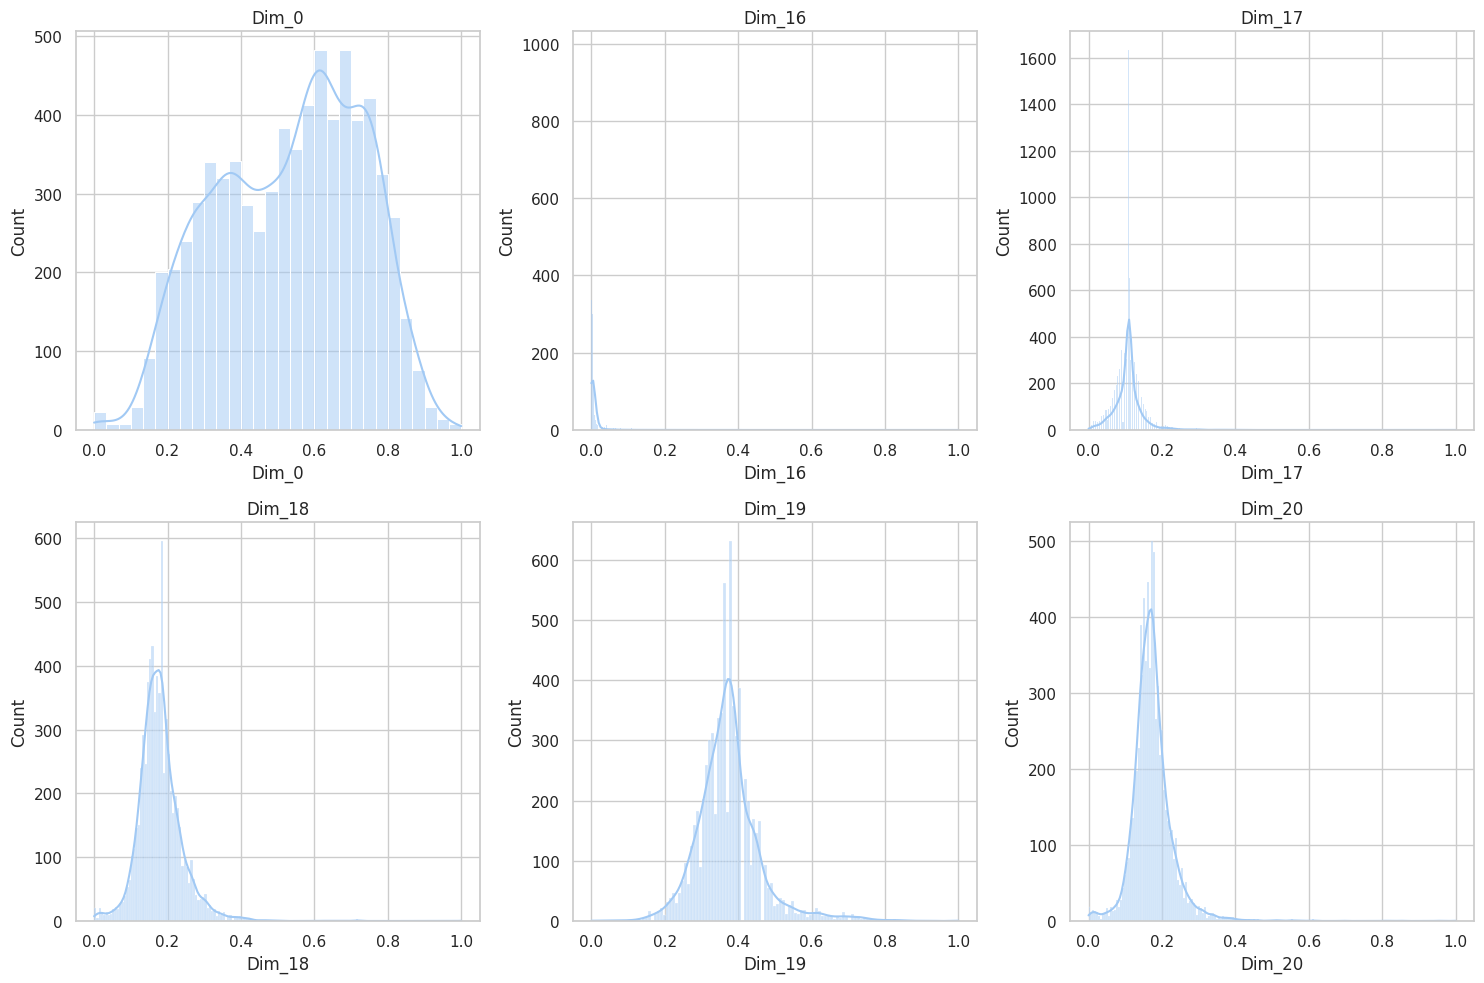

In [23]:
# number of rows and columns for subplots
num_rows = (len(df_continuous.columns) + 2) // 3  # compute the number of rows
num_cols = min(len(df_continuous.columns), 3)  #max 3 columns

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i, col in enumerate(df_continuous.columns):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]
    sns.histplot(df_continuous[col], ax=ax,kde=True)
    ax.set_title(col)

plt.tight_layout()
plt.show()

#### Univariate analysis-Binary attributes


We select only the binary features

In [24]:
df_binary= df.loc[:, [col for col in df.columns if df[col].dtype=='int64']]

In [25]:
df_binary.columns

Index(['Dim_1', 'Dim_2', 'Dim_3', 'Dim_4', 'Dim_5', 'Dim_6', 'Dim_7', 'Dim_8',
       'Dim_9', 'Dim_10', 'Dim_11', 'Dim_12', 'Dim_13', 'Dim_14', 'Dim_15'],
      dtype='object')

To inspect binary features we count the **number of occurence** for each variable
and we plot the **histogram**.

In this scenario, we observe a discrete distribution, specifically a Bernoulli distribution, as all variables are binary.

In [26]:
for col in df_binary.columns:
  print(f'{col} :\n{df_binary[col].value_counts()}')

Dim_1 :
Dim_1
1    4942
0    2187
Name: count, dtype: int64
Dim_2 :
Dim_2
1    6189
0     940
Name: count, dtype: int64
Dim_3 :
Dim_3
1    7018
0     111
Name: count, dtype: int64
Dim_4 :
Dim_4
1    7038
0      91
Name: count, dtype: int64
Dim_5 :
Dim_5
1    6853
0     276
Name: count, dtype: int64
Dim_6 :
Dim_6
1    7051
0      78
Name: count, dtype: int64
Dim_7 :
Dim_7
1    7028
0     101
Name: count, dtype: int64
Dim_8 :
Dim_8
1    7008
0     121
Name: count, dtype: int64
Dim_9 :
Dim_9
1    6657
0     472
Name: count, dtype: int64
Dim_10 :
Dim_10
1    6637
0     492
Name: count, dtype: int64
Dim_11 :
Dim_11
1    7038
0      91
Name: count, dtype: int64
Dim_12 :
Dim_12
1    7070
0      59
Name: count, dtype: int64
Dim_13 :
Dim_13
1    6945
0     184
Name: count, dtype: int64
Dim_14 :
Dim_14
1    7128
0       1
Name: count, dtype: int64
Dim_15 :
Dim_15
1    6777
0     352
Name: count, dtype: int64


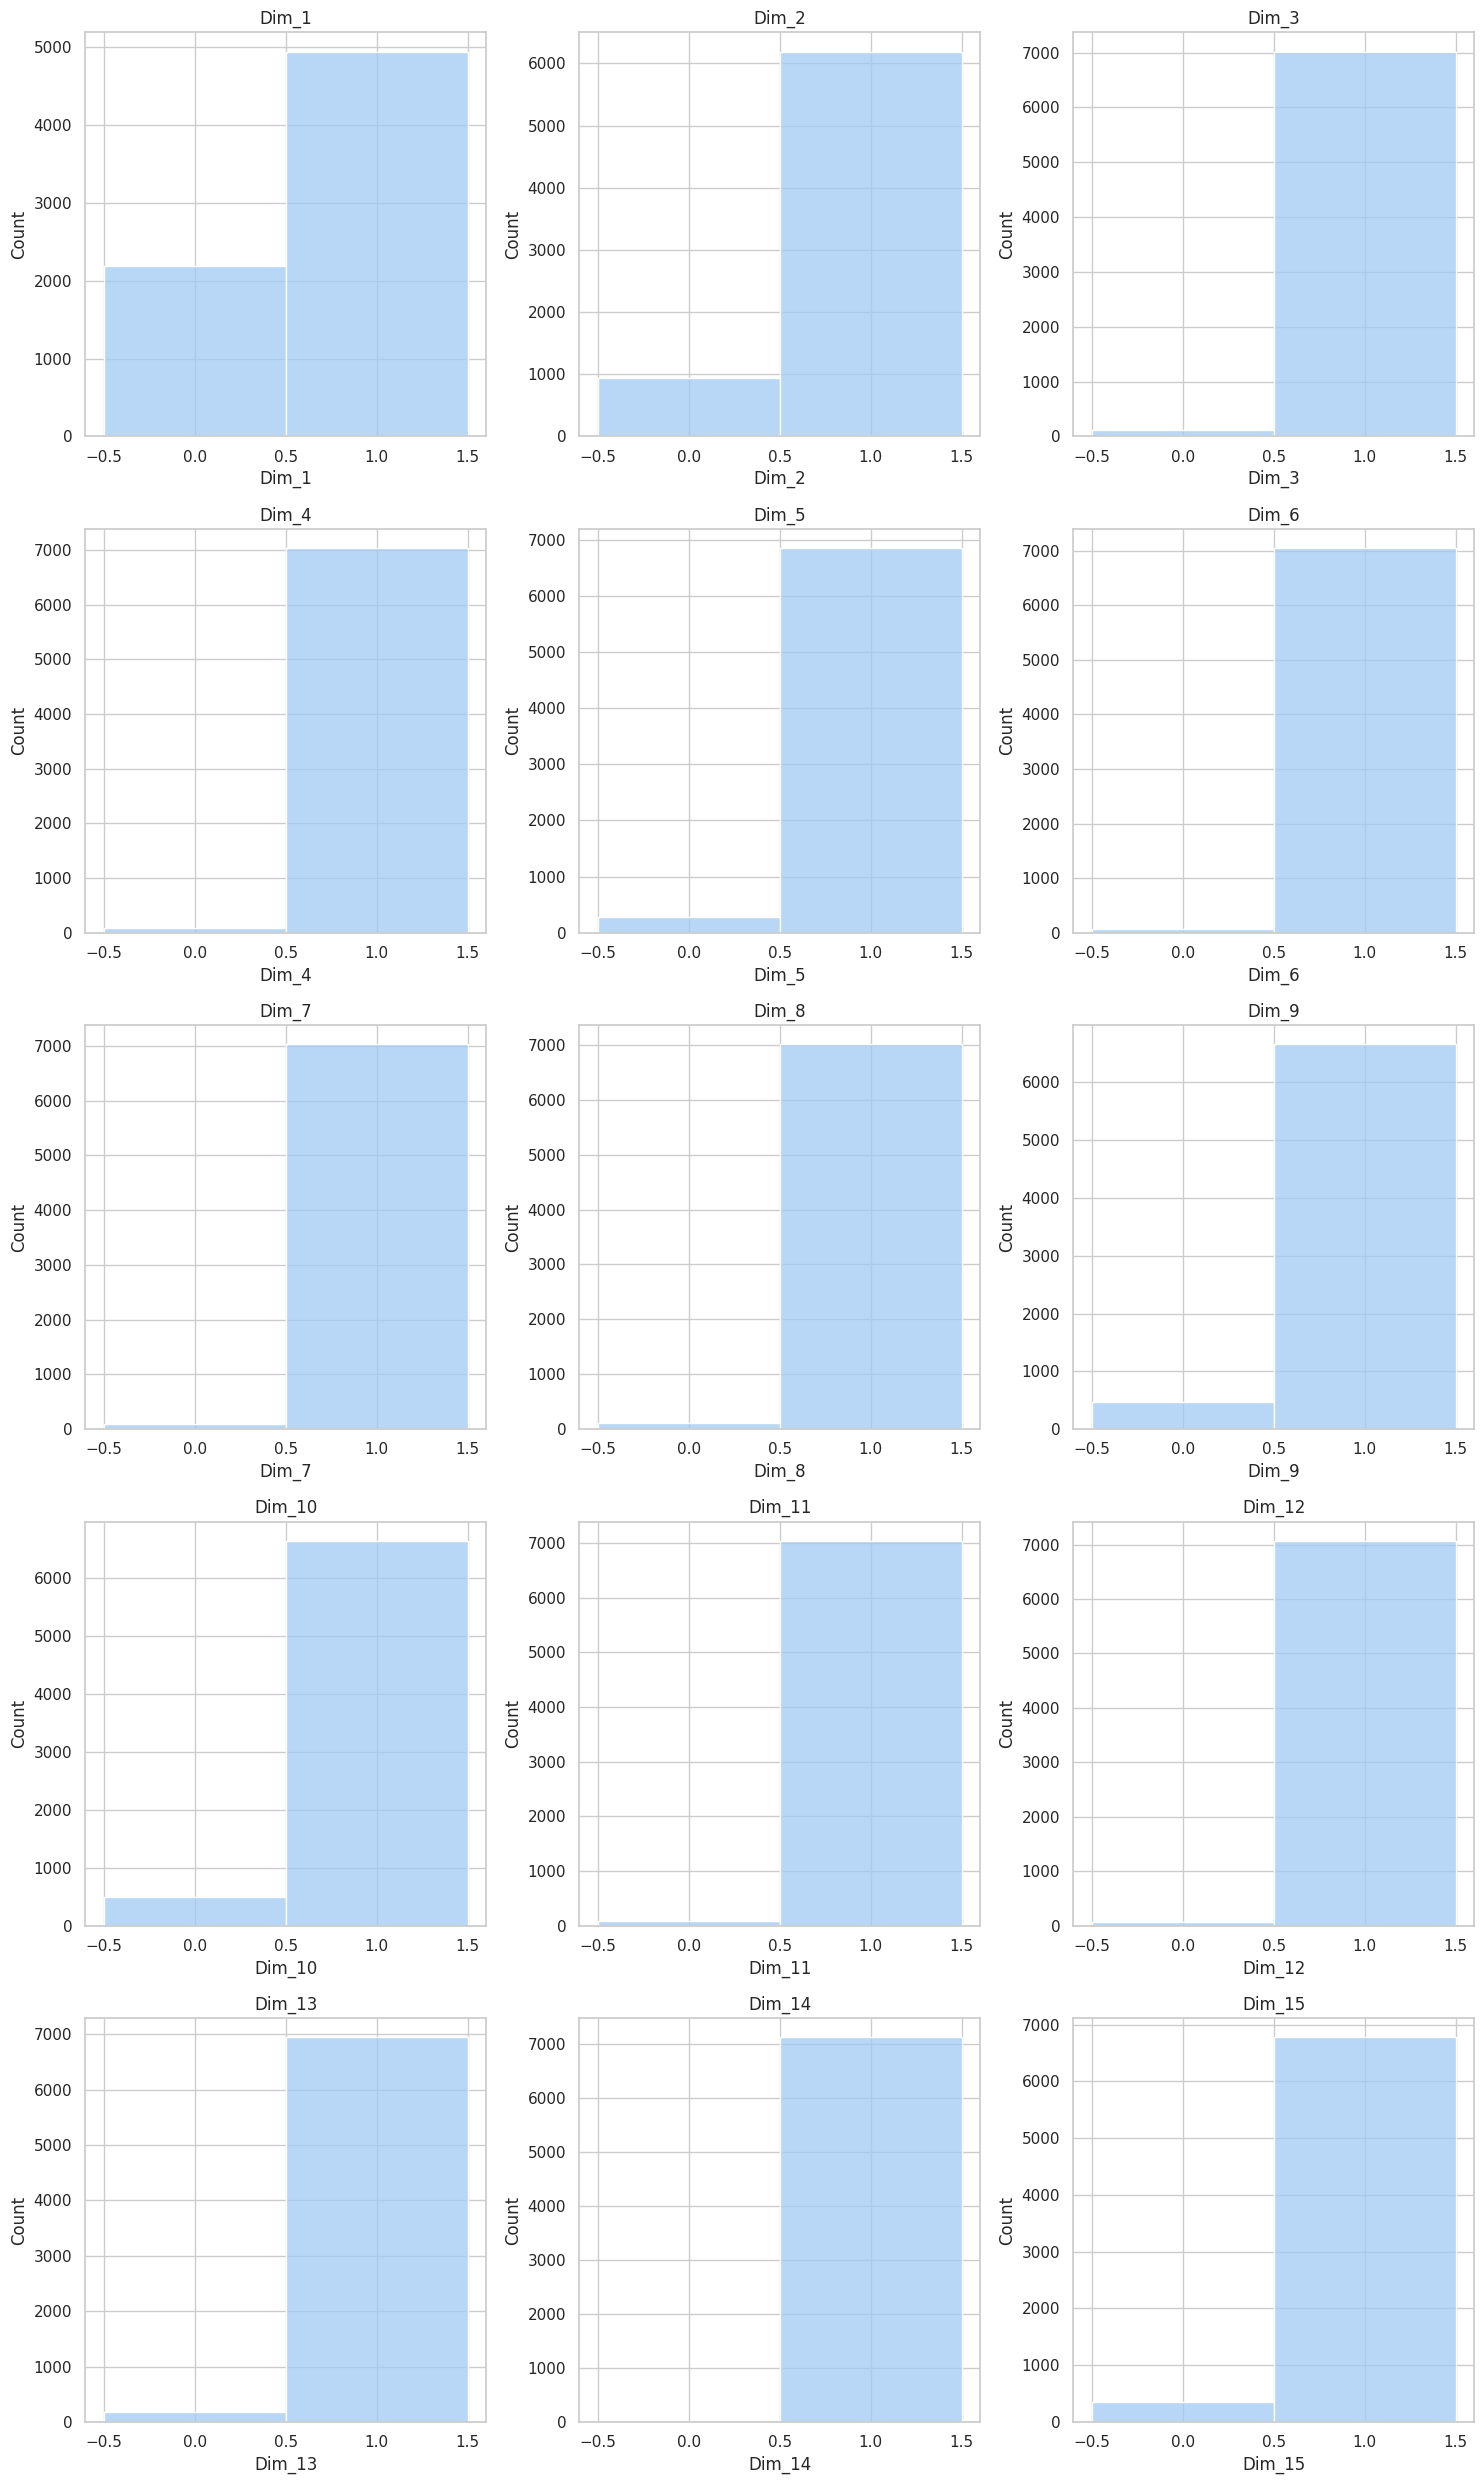

In [27]:
num_rows = (len(df_binary.columns) + 2) // 3
num_cols = min(len(df_binary.columns), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i, col in enumerate(df_binary.columns):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]
    sns.histplot(df_binary[col], ax=ax, discrete=True, binwidth=3)
    ax.set_title(col)

plt.tight_layout()
plt.show()

As we can see from the results, we have a smaller number of 0s compared to the number of 1s.

### Bivariate Analysis

Now, we analyze the variables pairwise to discover relationships between them.

Just as we've done previously, we'll analyze continuous variables and binary variables separately.


#### Bivariate Analysis-Continuous variables

To capture the relationship between attributes, we could utilize **correlation** analysis.

In this case, we decide not to standardize the variables because correlation is scale and location invariant, and also because, as we have seen before, they are within the same interval.

Although one of the assumptions of the Pearson coefficient is that the variables have to be normally distributed, we can still use it because leptokurtic distributions are close to normal distributions.

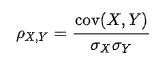

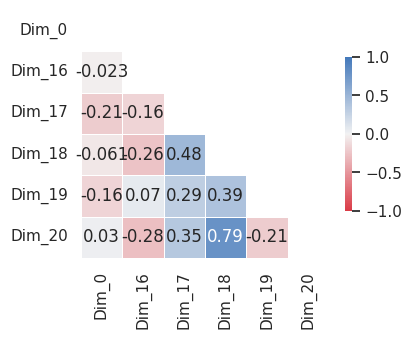

In [28]:
corr = df_continuous.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(4, 4))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr,
            annot=True,
            mask=mask,
            cmap=cmap,
            square=True,
            vmax=1,
            vmin=-1,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            ax=ax)

plt.show()


We plot scatter plots to visually inspect the correlation between variables.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


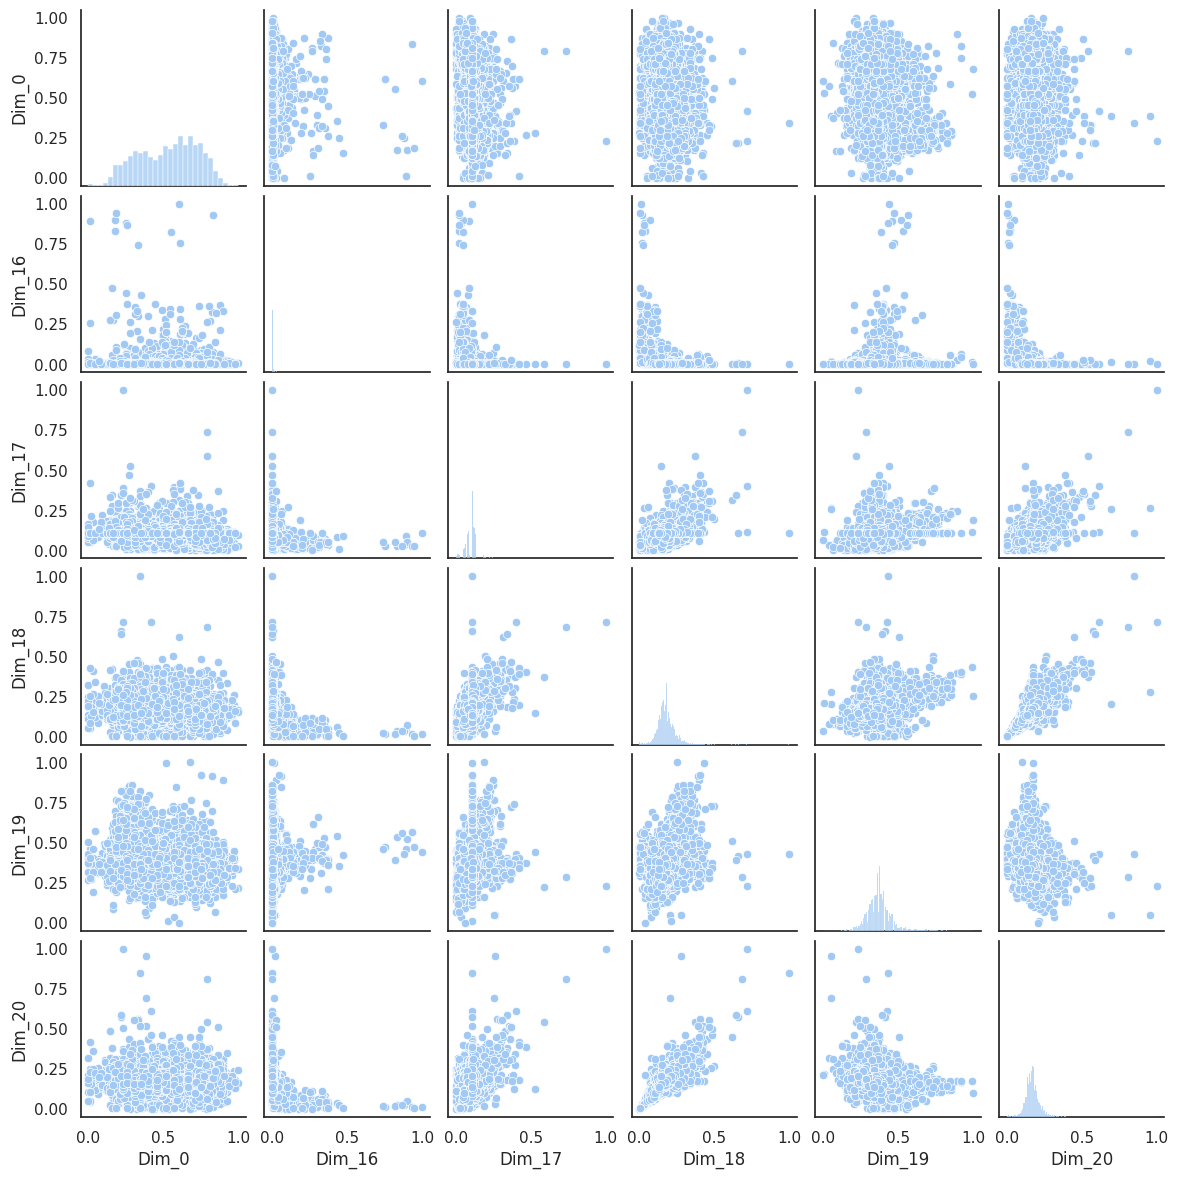

In [29]:
sns.pairplot(df_continuous, size = 2.0)
plt.show();

From these results, we can deduce that all the continuous variables are important. This is because they all exhibit relatively low correlation with each other

#### Bivariate Analysis-Discrete variables

To compare two binary attributes, we can use the **Jaccard Coefficient**. If the value is equal to 1, it indicates that the two attributes provide the same information, and we could consider removing one of them.

Since we can't not associate to each binary variable a semantic meaning ,like man or female, we can't remove effectively one attributes if they give the same information.

We can suppose that each of these variables its the result of a anamnesis.
Thus they should be like sympton or features of the patient.

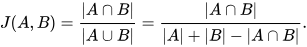

In [30]:
jaccard_matrix=np.zeros((df_binary.columns.shape[0],df_binary.columns.shape[0]))
for i in range(len(df_binary.columns)):
  for j in range(i,len(df_binary.columns)):
    jaccard_matrix[i,j]=jaccard_score(df_binary.iloc[:,i],df_binary.iloc[:,j])


<Axes: >

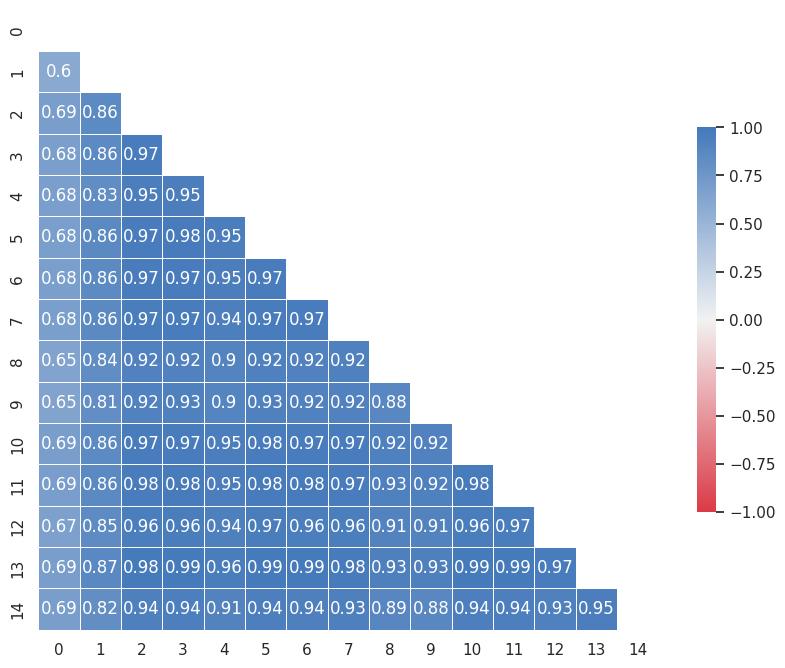

In [31]:
mask = np.triu(np.ones_like(jaccard_matrix, dtype=bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(jaccard_matrix.T,
            annot=True,
            mask=mask,
            cmap=cmap,
            square=True,
            vmax=1,
            vmin=-1,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            ax=ax)


The result dosn't give a lot of information.

The most informative attribute is the first one.

As we already mentioned, since this concerns anomaly detection and I don't know what these variables correspond to, we prefer not to remove them, even though this analysis indicates they are identical.

### Sample Analysis - Proximity matrix

Now, we analyze the relationship between samples.

#### Proximity matrix - All attributes

To determine how dissimilar two objects are, we compute a proximity matrix using **Gower Distance** as the distance metric.

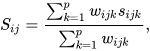

In [ ]:
dissimilarity_matrix= gower.gower_matrix(df)

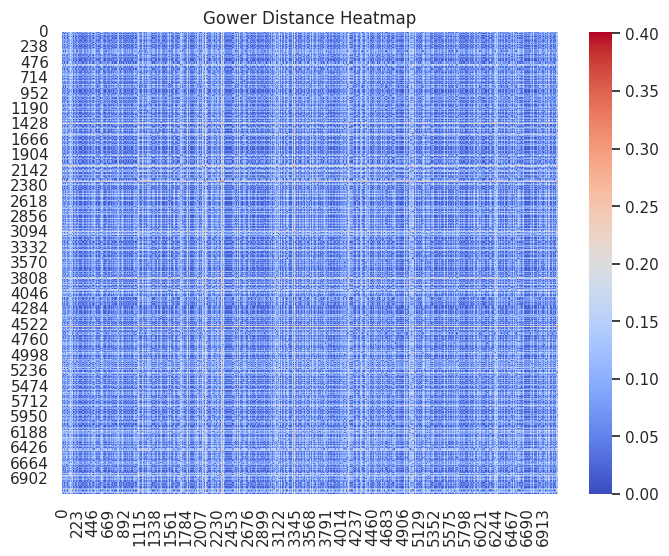

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(dissimilarity_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Gower Distance Heatmap')
plt.show()

From this result, we can already see that there are some samples different from the others, as indicated by the red lines

#### Proximity matrix - Only on continues variable

To compute the proximity matrix using only continuous attributes, we use the **L1 or Manhattan distance**. We opt for this distance metric because it is the same distance used in Gower for computing distances between continuous variables. It's important to note that in Gower, the distance is standardized.



image.png

In [ ]:
dissimilarity_matrix_c = pdist(df_continuous, metric='minkowski', p=1)
dissimilarity_matrix_c = squareform(dissimilarity_matrix_c).round(2)

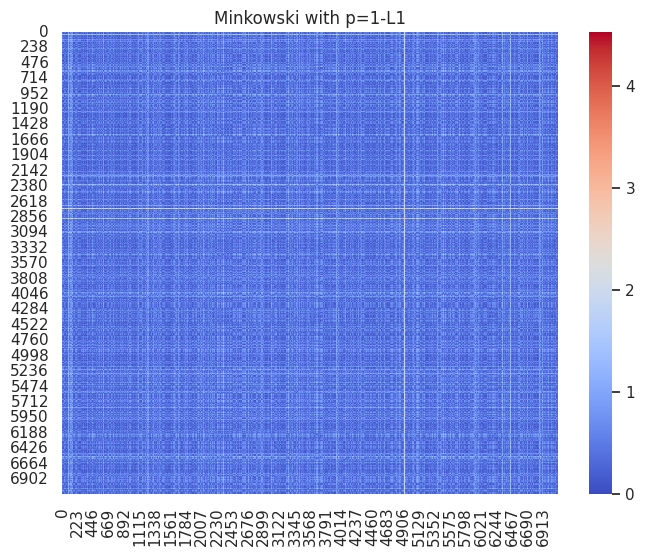

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(dissimilarity_matrix_c, annot=False, cmap='coolwarm', cbar=True)
plt.title('Minkowski with p=1-L1')
plt.show()

#### Proximity matrix - only on binary attributes

To compute the proximity matrix using only binary attributes, we use the **Hamming distance**.

In [32]:
dissimilarity_matrix_b = pdist(df_binary, metric='hamming')
dissimilarity_matrix_b = squareform(dissimilarity_matrix_b).round(2)

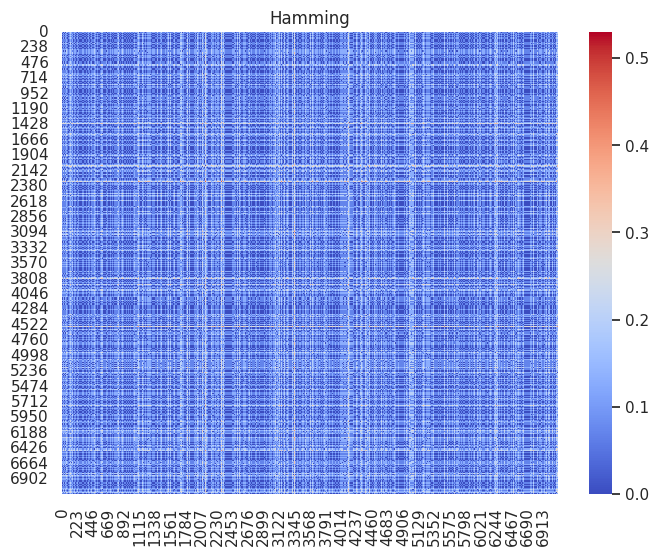

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(dissimilarity_matrix_b, annot=False, cmap='coolwarm', cbar=True)
plt.title('Hamming')
plt.show()

From these results, we can conclude that we need both continuous and binary variables to detect outliers because both of the results doesn't give enough information.

### Data visualization

To visualize the data, we cannot use PCA because our data are both continuous and binary, and PCA assumes that data are normally distributed.

Instead, we could use Factor Analysis for Mixed Data (FAMD) or **t-Distributed Stochastic Neighbor Embedding (t-SNE)**. We decided to use t-SNE because there is no linear relationship between the variables;FAMD is better to capture these relationship.



In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(df)

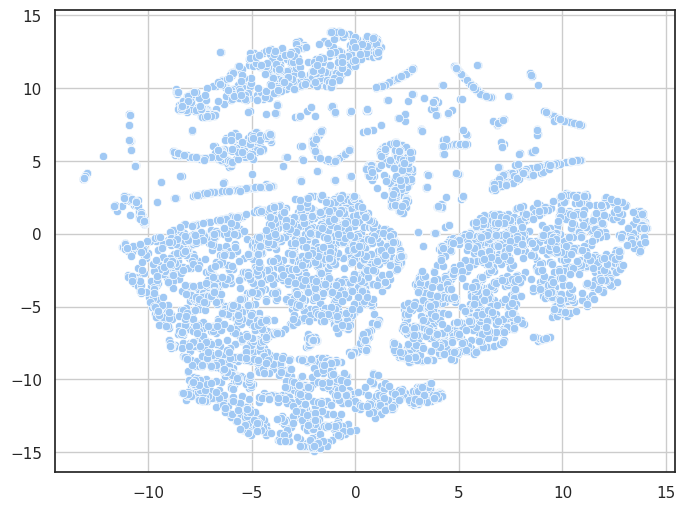

In [ ]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1])
plt.grid()
plt.show()

## Anomaly Detection

To detect the anomalies we will use four different approaches:
- DBSCAN
- LOF
- Auto Encoder
- MCD

To determine the number of contaminations,the possible fraction of outliers in the dataset, we first use the DBSCAN method, which does not require this parameter.

###Density-based clustering algorithm - DBSCAN

**DBSCAN** depends on two parameters:

- *MinPts*: Minimum number of points required to form a dense region (core point).
- *Eps*: Maximum distance that specifies the neighborhood of a point, which determines its core points and directly density-reachable points

To determine Eps, we compute the distance from each point to its 4th nearest neighbor **using k-nearest neighbors (KNN)**, and then sort these distances.

As the distance metric, we will use the Gower distance. Therefore, we will reuse the proximity matrix computed previously.

In [ ]:
neighborhood = NearestNeighbors(n_neighbors=4, metric='precomputed').fit(dissimilarity_matrix)
distances, indices = neighborhood.kneighbors(dissimilarity_matrix)

distances = np.sort(distances[:,3], axis=0)

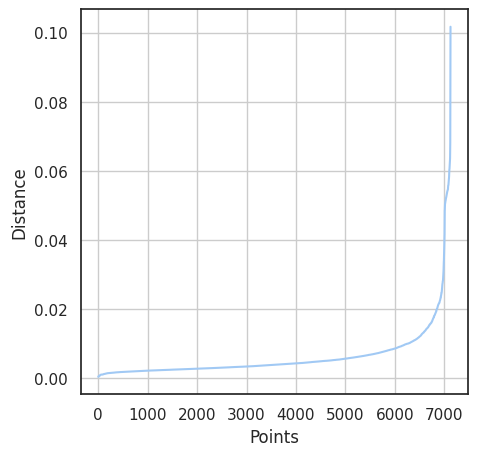

In [ ]:
fig1=plt.figure(figsize=(5,5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.grid()
plt.show()

We use the knee locator to indentify better the knee in the previous plot

In [ ]:
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

knee_x = knee.knee
knee_y = knee.knee_y
print(f'The estimated best eps value is {knee_y: .2f}')

The estimated best eps value is  0.01


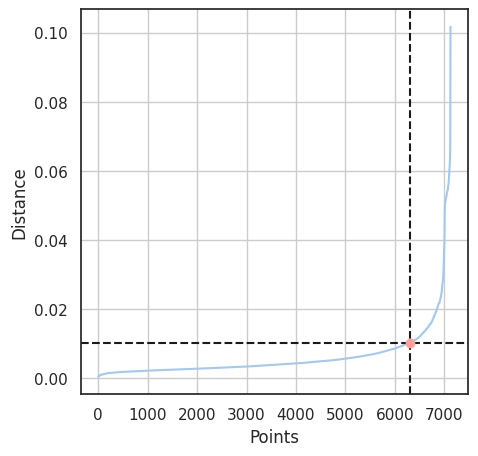

In [ ]:
plt.figure(fig1)
plt.axvline(x=knee_x, color='k', linestyle='--')
plt.axhline(y=knee_y, color='k', linestyle='--')
plt.plot((knee_x), (knee_y), 'o', color='r')
plt.show()

We select as eps value 0.01, since after it the distance increase 'exponentially'

We apply DBSCAN

In [ ]:
eps=0.01
min_samples=4

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(dissimilarity_matrix)
labels_dbscan = dbscan.labels_

We set the label of outliers to 1 and the label of normal data to 0,

In [ ]:
labels_dbscan = [1 if x == -1 else 0 for x in labels_dbscan]

We count the number of outliers and the number of normal data





In [ ]:
n_inliers_dbscan = len(labels_dbscan) - np.count_nonzero(labels_dbscan)
n_outliers_dbscan = np.count_nonzero(labels_dbscan)

In [ ]:
print(f'Number of normal data: {n_inliers_dbscan}')
print(f'Number of outlier data: {n_outliers_dbscan}')

Number of normal data: 6489
Number of outlier data: 640


We plot our data, indicating normal data and outliers with two different colors.

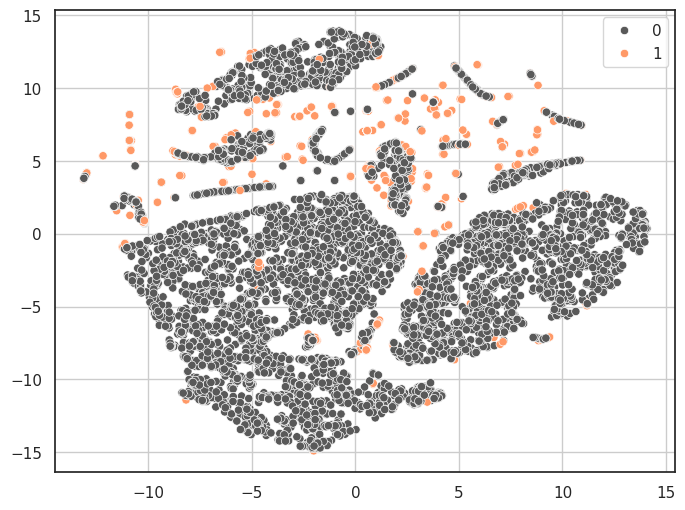

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1],hue=labels_dbscan, palette=custom_palette)
plt.grid()
plt.show()

We will use as contamination 0.1 becuse DBSCAN found 640 outliers which is about the 10% of the data

### Local outlier factor - LOF

We apply LOF using the contamination value found through DBSCAN. To choose the number of n_neighbors, we use the thumb rule, which suggests taking 20% of the data.

As the distance metric, we will use the Gower distance. Therefore, we will reuse the proximity matrix computed previously.

In [ ]:
contamination=0.1
n_neighbors=140

lof_model=lof.LOF(contamination=contamination,n_neighbors=n_neighbors,metric='precomputed').fit(dissimilarity_matrix)#threshold = contamination*sample
labels_lof=lof_model.predict(dissimilarity_matrix)
scores_lof=lof_model.decision_scores_

We count the number of outliers and the number of normal data


In [ ]:
n_inliers_lof = len(labels_lof) - np.count_nonzero(labels_lof)
n_outliers_lof = np.count_nonzero(labels_lof)

In [ ]:
print(f'Number of normal data: {n_inliers_lof}')
print(f'Number of outlier data: {n_outliers_lof}')

Numeber of normal data: 6422
Number of outlier data: 707


We plot the data using t-SNE and also the histogram of anomaly scores. This is useful for observing if the different methods exhibit similar behavior and if in general they behave in a reasonable manner.

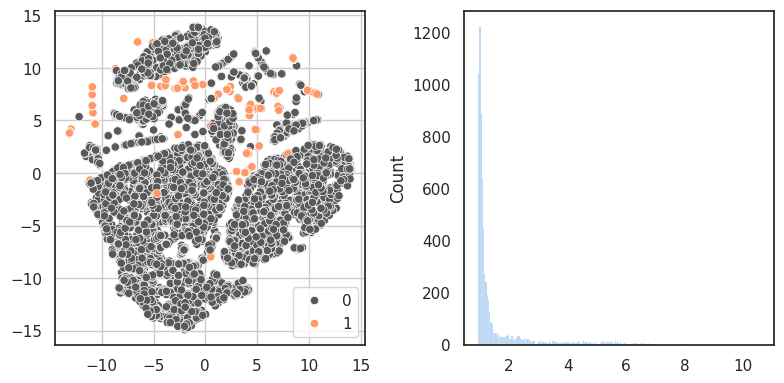

In [ ]:
fig, axs =plt.subplots(1,2, figsize=(8,4))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1],hue=labels_lof, palette=custom_palette, ax=axs[0])
axs[0].grid()

sns.histplot(data=scores_lof,binrange=(scores_lof.min(),scores_lof.max()),ax=axs[1])
plt.tight_layout()
plt.show()


### Auto-Encoder

We apply the auto-econder using as contamination the previous value.
The network will have 6 layers:
- Input layer 21 neurons
- 1st hidden layer 18 neurons
- 2nd hidden layer 9 neurons
- 3rd hidden layer 9 neurons
- 4th hidden layer 18 neurons
- Output layer 21 neurons


In [ ]:
contamination=0.1

auto_encoder_model=auto_encoder.AutoEncoder(hidden_neurons=[18,9,9,18],contamination=contamination).fit(df)
labels_auto_encoder=auto_encoder_model.predict(df)
scores_auto_encoder=auto_encoder_model.decision_scores_

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21)                462       
                                                                 
 dropout (Dropout)           (None, 21)                0         
                                                                 
 dense_1 (Dense)             (None, 21)                462       
                                                                 
 dropout_1 (Dropout)         (None, 21)                0         
                                                                 
 dense_2 (Dense)             (None, 18)                396       
                                                                 
 dropout_2 (Dropout)         (None, 18)                0         
                                                                 
 dense_3 (Dense)             (None, 9)                 1

In [ ]:
n_inliers_auto_encoder = len(labels_auto_encoder) - np.count_nonzero(labels_auto_encoder)
n_outliers_auto_encoder = np.count_nonzero(labels_auto_encoder == 1)

We count the number of outliers and the number of normal data


In [ ]:
print(f'Number of normal data: {n_inliers_auto_encoder}')
print(f'Number of outlier data: {n_outliers_auto_encoder}')

Numeber of normal data: 6416
Number of outlier data: 713


We plot the data and the histogram of anomaly scores.

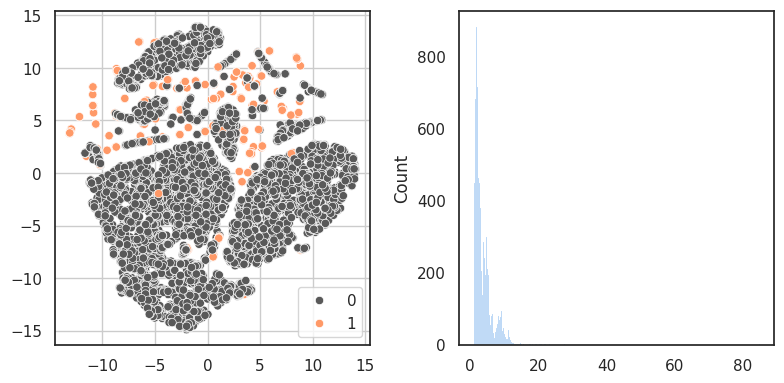

In [ ]:
fig, axs =plt.subplots(1,2, figsize=(8,4))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1],hue=labels_auto_encoder, palette=custom_palette, ax=axs[0])
axs[0].grid()

sns.histplot(data=scores_auto_encoder,binrange=(scores_auto_encoder.min(),scores_auto_encoder.max()),ax=axs[1])
plt.tight_layout()

plt.show()


### Minimum Covariance Determinant MCD


Even though we have observed that analyzing samples with only continuous attributes does not reveal any distinctive differences between them, we have decided to use the Minimum Covariance Determinant method. This is because it is a statistical method and could provide a different perspective on outliers.

To improve performance, we need to normalize the distributions of the data. To accomplish this, we apply the Yeo-Johnson transformation, but only to continuous variables with leptokurtic distributions.So we exclude the first attribute *Dim_0*

In [ ]:
pt = PowerTransformer()
df_continuous_Norm=pd.DataFrame(pt.fit_transform(df_continuous.iloc[:,1:]))
df_continuous_Norm.columns=df_continuous.columns[1:]

In [ ]:
df_continuous_Norm[df_continuous.columns[0]]=np.float64(df_continuous.iloc[:,1])

df_Norm=df.drop(df_continuous_Norm.columns,axis=1)
df_Norm[df_continuous_Norm.columns]=np.float64(df_continuous_Norm)


We apply MCD

In [ ]:
contamination=0.1
mcd_model=mcd.MCD(contamination=contamination).fit(df_continuous_Norm)
labels_mcd=mcd_model.predict(df_continuous_Norm)
scores_mcd=mcd_model.decision_scores_

In [ ]:
n_inliers_mcd = len(labels_mcd) - np.count_nonzero(labels_mcd)
n_outliers_mcd = np.count_nonzero(labels_mcd == 1)

We count the number of outliers and the number of normal data


In [ ]:
print(f'Number of normal data: {n_inliers_mcd}')
print(f'Number of outlier data: {n_outliers_mcd}')

Number of normal data: 6416
Number of outlier data: 713


We plot the data and the histogram of anomaly scores.

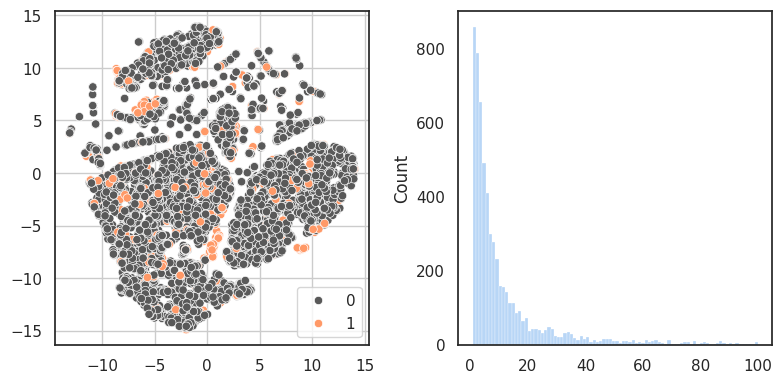

In [ ]:
fig, axs =plt.subplots(1,2, figsize=(8,4))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1],hue=labels_mcd,palette=custom_palette, ax=axs[0])
axs[0].grid()

# I set the maximum to 100 but the values is bigger scores_mcd.max() because we
#want only to see if it behaves in a reasonable manner
sns.histplot(data=scores_mcd,binrange=(scores_mcd.min(),100),ax=axs[1])
plt.tight_layout()

plt.show()


As seen from the plot, the points flagged as outliers by MCD are completely different from those identified by the other methods. Therefore, we will not use this method in the next analysis.

## Check coherence between outlier detection models



To check the difference between the models we compare the histogramm by using the **mutual information**.

The mutual information score indicates the amount of information shared between the two histograms: a higher score suggests more shared information, while a lower score suggests less shared information.

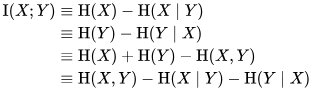

To compare the scores, since they represent two different metrics, namely the local outlier factor and reconstruction error, we standardize the values by using Min-Max Scaler.So they fall within the interval \[0,1]

In [ ]:
scaler = MinMaxScaler()
scores_auto_encoder_norm = scaler.fit_transform(scores_auto_encoder.reshape(-1, 1))
scores_lof_norm = scaler.fit_transform(scores_lof.reshape(-1, 1))

In [ ]:
hist_auto_encoder, bin_edges_auto_encoder = np.histogram(scores_auto_encoder_norm, bins=len(scores_auto_encoder_norm))
hist_lof, bin_edges_lof = np.histogram(scores_lof_norm,  bins=len(scores_auto_encoder_norm))

print("Histogram for scores_auto_encoder_norm:")
print(hist_auto_encoder)
print("Bin Edges:")
print(bin_edges_auto_encoder)

print("\nHistogram for scores_lof_norm:")
print(hist_lof)
print("Bin Edges:")
print(bin_edges_lof)


Histogram for scores_auto_encoder_norm:
[ 8 11  5 ...  0  0  1]
Bin Edges:
[0.00000000e+00 1.40272128e-04 2.80544256e-04 ... 9.99719456e-01
 9.99859728e-01 1.00000000e+00]

Histogram for scores_lof_norm:
[2 0 4 ... 0 0 1]
Bin Edges:
[0.0000000e+00 1.4027212e-04 2.8054425e-04 ... 9.9971944e-01 9.9985975e-01
 1.0000000e+00]


In [ ]:
mi_score = metrics.mutual_info_score(hist_auto_encoder, hist_lof)

print(f"Mutual Information Score: {mi_score:.3f}")

Mutual Information Score: 0.273


Also we compare the labels by using **jaccard score**

In [ ]:
lof_encoder=jaccard_score(labels_lof,labels_auto_encoder)
lof_dbscan=jaccard_score(labels_lof,labels_dbscan)
encoder_dbscan=jaccard_score(labels_auto_encoder,labels_dbscan)


print(f'Jaccard Coefficient LOF-Encoder {lof_encoder:.2f}')
print(f'Jaccard Coefficient LOF-DBSCAN {lof_dbscan:.2f}')
print(f'Jaccard Coefficient Encoder-DBSCAN {encoder_dbscan:.2f}')

Jaccard Coefficient LOF-Encoder 0.56
Jaccard Coefficient LOF-DBSCAN 0.22
Jaccard Coefficient Encoder-DBSCAN 0.36


As we can see lof and auto encoder are the two methods that have most labels in common.

## Delete Outlier

We create four different dataframes by removing the outliers found by each method:

1. *df_lof*: dataframe without the outliers found by LOF
2. *df_encoder*: dataframe without the outliers found by Auto-Encoder
3. *df_dbscan*: dataframe without the outliers found by DBSCAN
4. *df_encoder_lof*: dataframe without the outliers found in common between LOF and Auto-Encoder.


In [ ]:
df_lof = np.delete(df, [np.where(labels_lof==1)], axis=0)
df_encoder= np.delete(df, [np.where(labels_auto_encoder==1)], axis=0)
df_dbscan= np.delete(df, [np.where(labels_dbscan)], axis=0)

labels_lof_encoder= (labels_lof == 1) & (labels_auto_encoder == 1)
df_encoder_lof=np.delete(df, [np.where(labels_lof_encoder==True)], axis=0)

Shapes of dataframes

In [ ]:
print(df_lof.shape)
print(df_encoder.shape)
print(df_dbscan.shape)
print(df_encoder_lof.shape)

(6422, 21)
(6416, 21)
(6489, 21)
(6622, 21)


We plot the dataframes without outliers

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=300)
tsne_results_lof = tsne.fit_transform(df_lof)

tsne = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=300)
tsne_results_encoder = tsne.fit_transform(df_encoder)

tsne = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=300)
tsne_results_dbscan = tsne.fit_transform(df_dbscan)

tsne = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=300)
tsne_results_encoder_lof = tsne.fit_transform(df_encoder_lof)


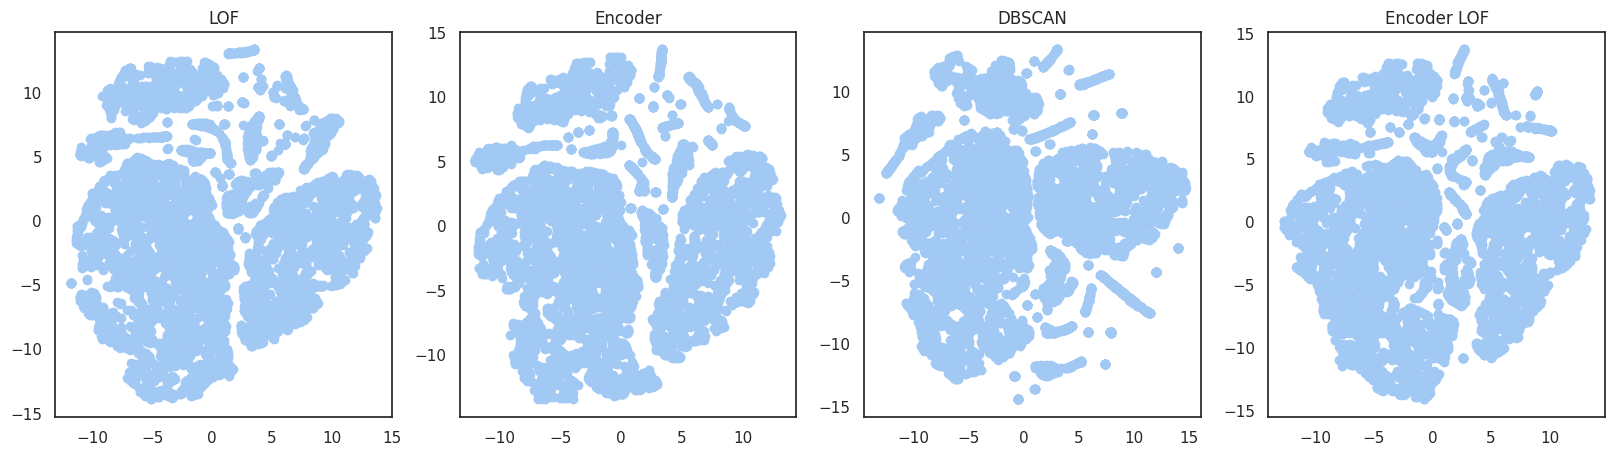

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].scatter(tsne_results_lof[:, 0], tsne_results_lof[:, 1])
axs[0].set_title('LOF')

axs[1].scatter(tsne_results_encoder[:, 0], tsne_results_encoder[:, 1])
axs[1].set_title('Encoder')

axs[2].scatter(tsne_results_dbscan[:, 0], tsne_results_dbscan[:, 1])
axs[2].set_title('DBSCAN')

axs[3].scatter(tsne_results_encoder_lof[:, 0], tsne_results_encoder_lof[:, 1])
axs[3].set_title('Encoder LOF')

plt.show()

## Visualize Clustering with and without outliers

To evaluate the different methods of outlier detection, we apply **k-means** to the different dataframes and assess the results using the Silhouette Score.

Although our dataset may not be well-suited for k-means due to its small variance, we use this method only as a reference point. We expect a poor result across all methods, but we can still determine the best one.

Note that if we want to determine the "correct" number of clusters we should explore also the results by using metrics like BIC AIC or adjust that coniser the number of clusters in their computation.

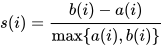

### K-Means

To determine the number of cluster we use the **elbow method**.
We use K-means ++ since it doesn't suffer less form the initialization problem.

Altough the number of cluster is not really important in this case, and we always use the same number of cluster, for reason explained before.

In [ ]:
inertia_values = np.zeros(19)

i=0
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(df)
    inertia_values[i] = kmeans.inertia_
    i=i+1

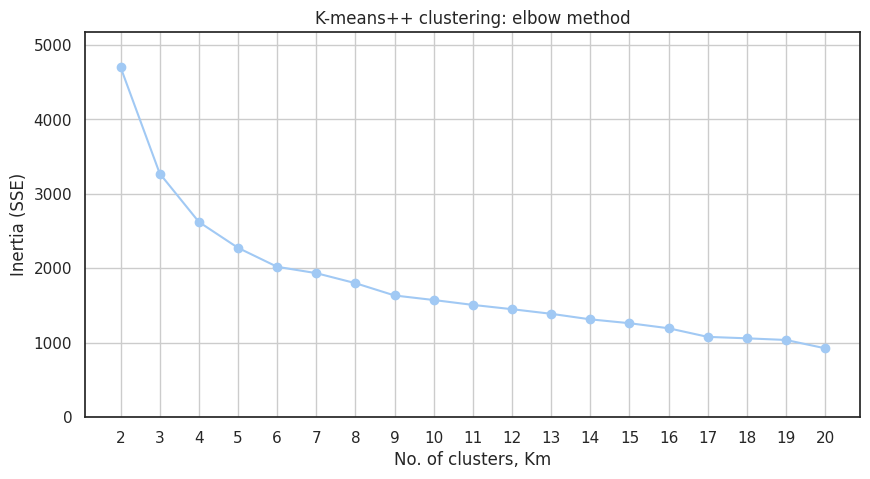

In [ ]:
# Elbow method.
plt.figure('K-means++ clustering: the elbow method', figsize=(10,5))
plt.plot(range(2,21), inertia_values, marker="o", linestyle="-")
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel('No. of clusters, Km')
plt.ylabel('Inertia (SSE)')
plt.ylim([0, 1.1*np.max(inertia_values)])
plt.title("K-means++ clustering: elbow method")
plt.grid()
plt.show()

We select as number of cluster 10.

In [ ]:
k=10
kmeans= KMeans(n_clusters=k, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(df)
kmeans_labels  = kmeans.labels_
kmeans_inertia = kmeans.inertia_


We plot the clustered data

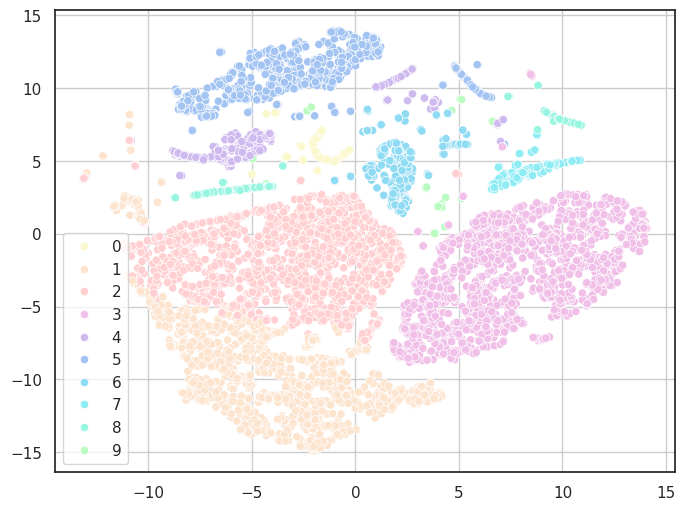

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1],hue=kmeans_labels, palette=pastel_palette)
plt.grid()
plt.show()

We compute the silhoutthe score

In [ ]:
silhouette_score_list=[]
Sm = silhouette_score(X=df ,labels=kmeans_labels, metric='manhattan')
print(f'Silhoutte score: {Sm}')
silhouette_score_list.append(dict([
    ('Model', 'Kmeans'),
    ('Silhoutte Score', round(Sm, 3))]))

Silhoutte score: 0.3872954434510264


###K-Means LOF

We apply the elbow method, to analyze any alterations in the data without outliers

In [ ]:
inertia_values = np.zeros(19)

i=0
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(df_lof)
    inertia_values[i] = kmeans.inertia_
    i=i+1

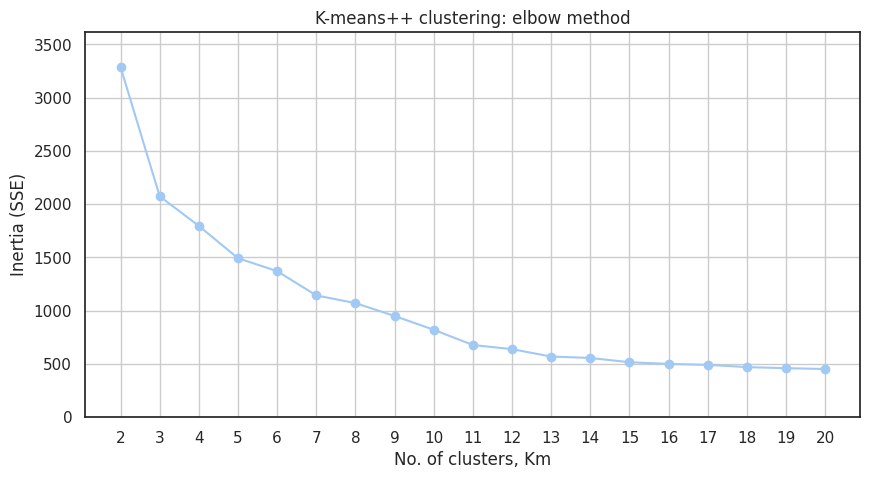

In [ ]:
# Elbow method.
plt.figure('K-means++ clustering: the elbow method', figsize=(10,5))
plt.plot(range(2,21), inertia_values, marker="o", linestyle="-")
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel('No. of clusters, Km')
plt.ylabel('Inertia (SSE)')
plt.ylim([0, 1.1*np.max(inertia_values)])
plt.title("K-means++ clustering: elbow method")
plt.grid()
plt.show()

We apply k-means with k=10


In [ ]:
k=10
kmeans= KMeans(n_clusters=10, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(df_lof)
kmeans_labels  = kmeans.labels_
kmeans_inertia = kmeans.inertia_

We plot the clustered data

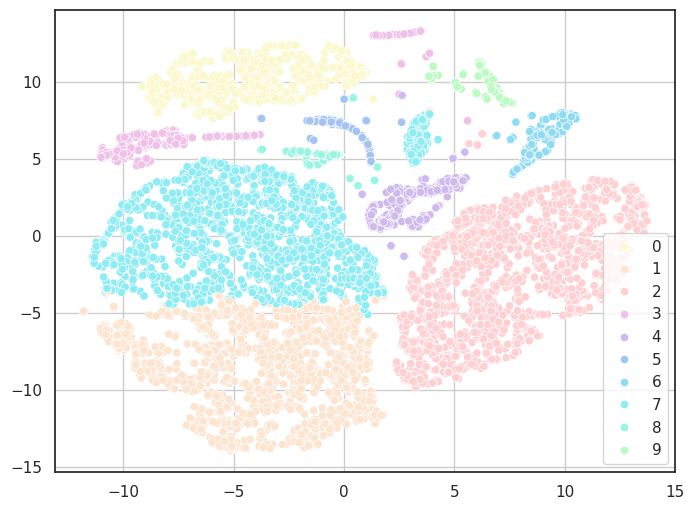

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results_lof[:,0], y=tsne_results_lof[:,1],hue=kmeans_labels, palette=pastel_palette)
plt.grid()
plt.show()

We compute the silhoutthe score

In [ ]:
Sm = silhouette_score(X=df_lof ,labels=kmeans_labels, metric='manhattan')
print(f'Silhoutte score: {Sm}')
silhouette_score_list.append(dict([
    ('Model', 'Kmeans-LOF'),
    ('Silhoutte Score', round(Sm, 3))]))

Silhoutte score: 0.4582021794055923


### K-Means Auto-Encoder

We apply the elbow method, to analyze any alterations in the data without outliers

In [ ]:
inertia_values = np.zeros(19)#is the error/loss to each run

i=0
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(df_encoder)
    inertia_values[i] = kmeans.inertia_
    i=i+1

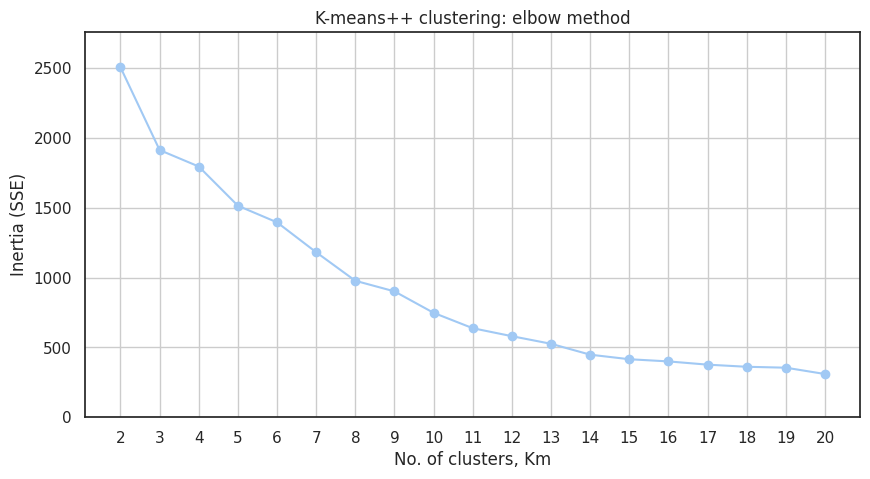

In [ ]:
# Elbow method. Hint: Plot SSE values vs the number of clusters
plt.figure('K-means++ clustering: the elbow method', figsize=(10,5))
plt.plot(range(2,21), inertia_values, marker="o", linestyle="-")
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel('No. of clusters, Km')
plt.ylabel('Inertia (SSE)')
plt.ylim([0, 1.1*np.max(inertia_values)])
plt.title("K-means++ clustering: elbow method")
plt.grid()
plt.show()

We apply k-means with k=10


In [ ]:
k=10
kmeans= KMeans(n_clusters=k, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(df_encoder)
kmeans_labels  = kmeans.labels_
kmeans_inertia = kmeans.inertia_

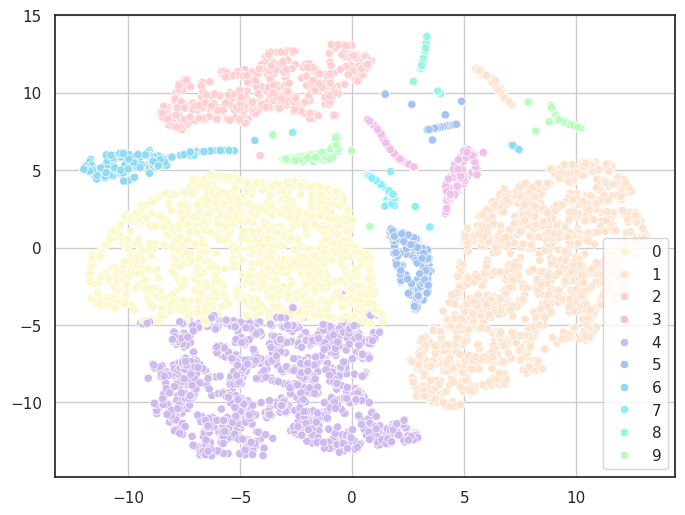

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results_encoder[:,0], y=tsne_results_encoder[:,1],hue=kmeans_labels, palette=pastel_palette)
plt.grid()
plt.show()

We compute the silhoutthe score

In [ ]:
Sm = silhouette_score(X=df_encoder ,labels=kmeans_labels, metric='manhattan')
print(f'Silhoutte score: {Sm}')
silhouette_score_list.append(dict([
    ('Model', 'Kmeans-Encoder'),
    ('Silhoutte Score', round(Sm, 3))]))

Silhoutte score: 0.45314079267678


### K-Means DBSCAN

We apply the elbow method, to analyze any alterations in the data without outliers

In [ ]:
inertia_values = np.zeros(19)#is the error/loss to each run

i=0
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(df_dbscan)
    inertia_values[i] = kmeans.inertia_
    i=i+1

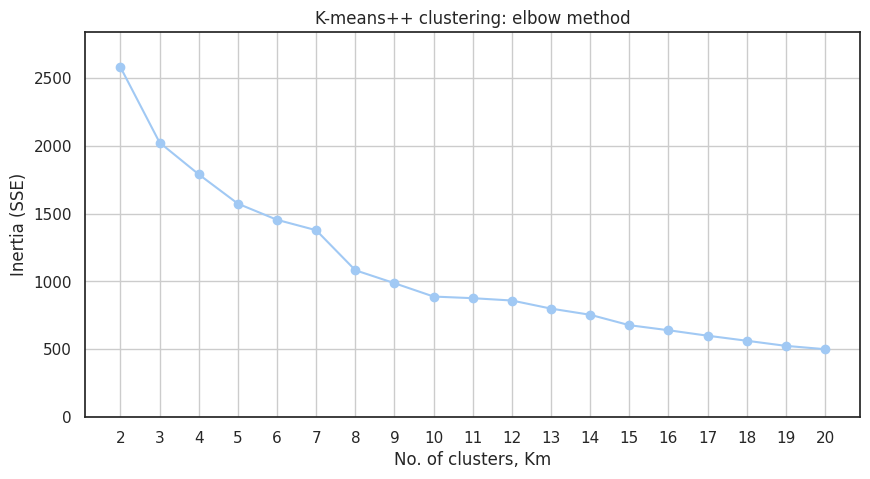

In [ ]:
# Elbow method. Hint: Plot SSE values vs the number of clusters
plt.figure('K-means++ clustering: the elbow method', figsize=(10,5))
plt.plot(range(2,21), inertia_values, marker="o", linestyle="-")
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel('No. of clusters, Km')
plt.ylabel('Inertia (SSE)')
plt.ylim([0, 1.1*np.max(inertia_values)])
plt.title("K-means++ clustering: elbow method")
plt.grid()
plt.show()

We apply k-means with k=10


In [ ]:
k=10
kmeans= KMeans(n_clusters=k, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(df_dbscan)
kmeans_labels  = kmeans.labels_
kmeans_inertia = kmeans.inertia_

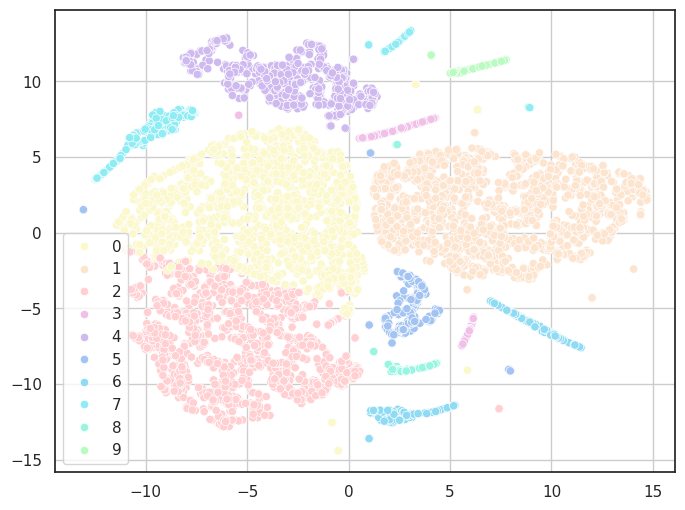

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results_dbscan[:,0], y=tsne_results_dbscan[:,1],hue=kmeans_labels, palette=pastel_palette)
plt.grid()
plt.show()

We compute the silhoutthe score

In [ ]:
Sm = silhouette_score(X=df_dbscan ,labels=kmeans_labels, metric='manhattan')
print(f'Silhoutte score: {Sm}')
silhouette_score_list.append(dict([
    ('Model', 'Kmeans-DBSCAN'),
    ('Silhoutte Score', round(Sm, 3))]))

Silhoutte score: 0.45059946240678306


### K-Means LOF-Encoder

We apply the elbow method, to analyze any alterations in the data without outliers

In [ ]:
inertia_values = np.zeros(19)#is the error/loss to each run

i=0
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(df_encoder_lof)
    inertia_values[i] = kmeans.inertia_
    i=i+1

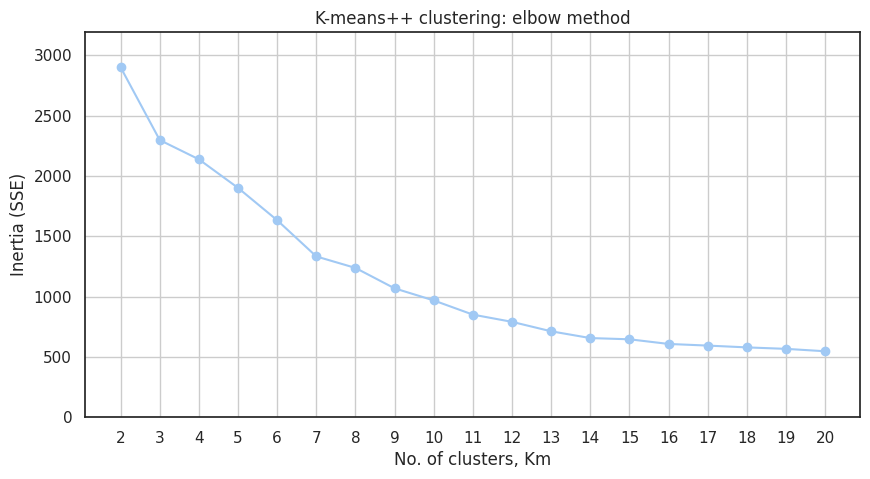

In [ ]:
# Elbow method. Hint: Plot SSE values vs the number of clusters
plt.figure('K-means++ clustering: the elbow method', figsize=(10,5))
plt.plot(range(2,21), inertia_values, marker="o", linestyle="-")
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel('No. of clusters, Km')
plt.ylabel('Inertia (SSE)')
plt.ylim([0, 1.1*np.max(inertia_values)])
plt.title("K-means++ clustering: elbow method")
plt.grid()
plt.show()

We apply k-means with k=10

In [ ]:
k=10
kmeans= KMeans(n_clusters=k, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(df_encoder_lof)
kmeans_labels  = kmeans.labels_
kmeans_inertia = kmeans.inertia_

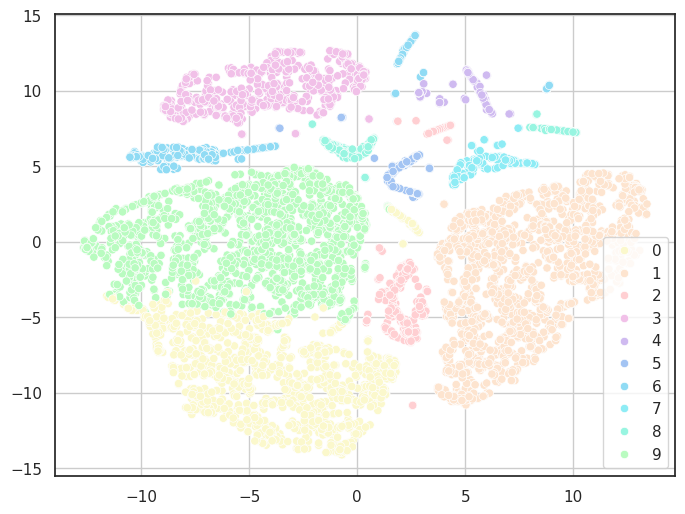

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results_encoder_lof[:,0], y=tsne_results_encoder_lof[:,1],hue=kmeans_labels, palette=pastel_palette)
plt.grid()
plt.show()

We compute the silhoutthe score

In [ ]:
Sm = silhouette_score(X=df_encoder_lof ,labels=kmeans_labels, metric='manhattan')
print(f'Silhoutte score: {Sm}')
silhouette_score_list.append(dict([
    ('Model', 'Kmeans-LOF Encoder'),
    ('Silhoutte Score', round(Sm, 3))]))


Silhoutte score: 0.44352236532965605


## Comparison

We compare all the results.

In [ ]:
results = pd.DataFrame(data=silhouette_score_list)
results = results[['Model','Silhoutte Score']]

results = results.sort_values(by='Silhoutte Score', ascending=False)

results

Model  Silhoutte Score
1          Kmeans-LOF            0.458
2      Kmeans-Encoder            0.453
3       Kmeans-DBSCAN            0.451
4  Kmeans-LOF Encoder            0.444
0              Kmeans            0.387

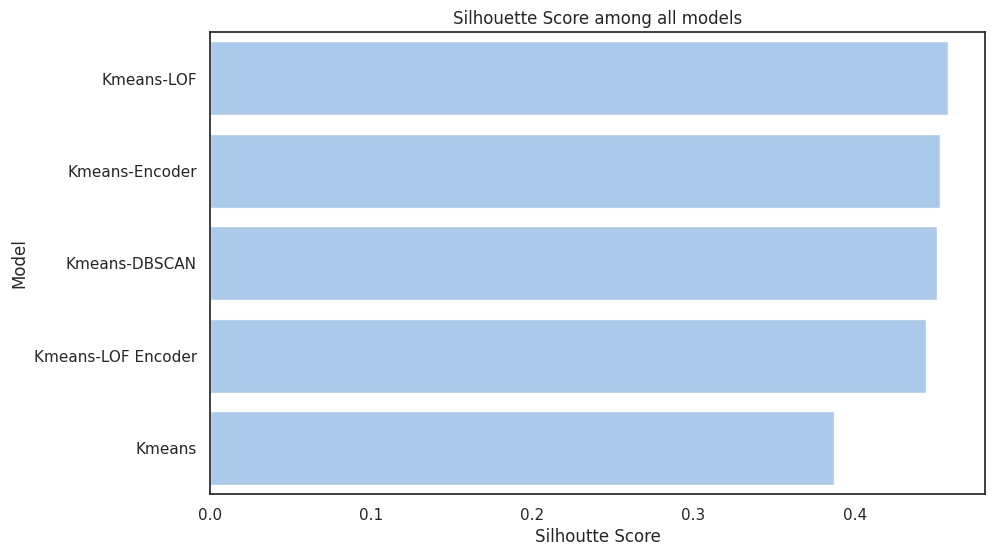

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Silhoutte Score', y='Model', data=results)
plt.title('Silhouette Score among all models')
plt.show()

As anticipated, the results are not very satisfactory. However, in all cases, we observe improved performance compared to the dataset including all data points.

The LOF algorithm demonstrates the best performance.

It's worth noting that the dataframe excluding outliers identified by both LOF and auto-encoder also performs well compared to the others, even though it removes fewer outliers.

## Probability computation

To assign to each sample the the probaility of the data object being
anomalous we have to compute the following probabity:

P(A=anoumalous|X1,X2,...Xn)

To compute this score, we will use Bayes' Theorem:

P(A=anom|X)=P(X|A=anom)*P(A=anom)/P(X)

where

- X=\{X1,X2,...Xn}

- P(X1,X2,...,Xn)=P(X|A=anom)*P(A=anom)+ P(X|A=normal)*P(A=normal)

Compunting the prior probability is straightforward; it's the number of outliers divided by the total number of samples.

To compute P(X1,X2,...Xn|A) we use anomaly scores computed by LOF (Local Outlier Factor). We chose LOF because it performed best among all models we analyzed.

To transform our score into a probability, there are three potential methods:
1. we could model our score to a distribution, if we now the distribution of the scores.
2. we could use Kernel Density Estimation
3. we can use the sigmoid function.

We opted for the sigmoid function because it is simpler and does not require knowledge of the score distribution. Therefore, we do not need to compute Bayes' Theorem directly and can apply sigmoid function directly.

If we use the sigmoid function, it is crucial to standardize our values to prevent the function from compressing the values too much, especially if the scores have high variance."

We standardize the scores

In [ ]:
scaler = StandardScaler()
scores_lof_standard = scaler.fit_transform(scores_lof.reshape(-1, 1))

We plot the histogramm

array([[<Axes: title={'center': '0'}>]], dtype=object)

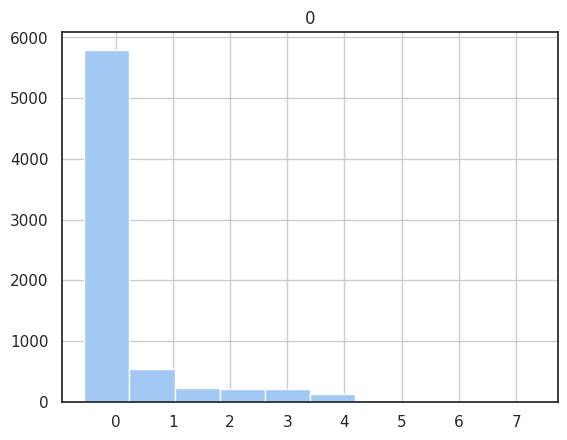

In [ ]:
pd.DataFrame(scores_lof_standard).hist()

We can see that we cannot use the normal to model the scores in any case

We compute the sigmoid

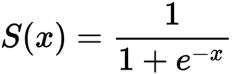

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

We apply it to compute the probabilities

In [ ]:
probabilities = sigmoid(scores_lof_standard)
print(f'Number of probabilities: {len(probabilities)}')

Number of probabilities: 7129


In [ ]:
df['Anomaly_Probabilty']=probabilities
df['Anomaly']=labels_lof

In [ ]:
df[['Anomaly','Anomaly_Probabilty']].sample(10)

Anomaly  Anomaly_Probabilty
3012        0            0.368795
6225        0            0.369883
5399        0            0.369970
4255        0            0.371542
405         1            0.903388
6999        0            0.515087
3419        0            0.379816
3715        0            0.374490
4803        0            0.677050
2472        0            0.379833

We select only the outliers

In [ ]:
selected_data = df.loc[df['Anomaly'] == 1, ['Anomaly_Probabilty']]


In [ ]:
selected_data

Anomaly_Probabilty
0               0.895278
19              0.916213
30              0.974046
38              0.953357
39              0.927224
...                  ...
7162            0.932772
7164            0.895580
7169            0.826131
7177            0.888731
7187            0.892245

[707 rows x 1 columns]